In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

***Gaussian Process with monotonicity constraint.***
=====

In [1]:
import pystan
import numpy as np
import matplotlib.pyplot as plt
import scipy
from sklearn import preprocessing
import pickle
from hashlib import md5
import time
import os

def StanModel_cache(model_code, model_name=None, **kwargs):
    
    path = "../Stan files/pkl_cache"
    if(os.path.isdir(path)==False):
        os.makedirs(path)
    
    code_hash = md5(model_code.encode('ascii')).hexdigest()
    if model_name is None:
        cache_fn = '{}/cached-model-{}.pkl'.format(path,code_hash)
    else:
        cache_fn = '{}/cached-{}-{}.pkl'.format(path,model_name, code_hash)
    try:
        sm = pickle.load(open(cache_fn, 'rb'))
    except:
        sm = pystan.StanModel(model_code=model_code)
        with open(cache_fn, 'wb') as f:
            pickle.dump(sm, f)
    else:
        print("Using cached StanModel")
    return sm

In [2]:
prior_model = StanModel_cache(model_code=open("../Stan files/prior.stan").read())

Using cached StanModel


In [3]:
mono_prior_model = StanModel_cache(model_code=open("../Stan files/prior mono.stan").read())

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e85dcc8746af27eed7d57d0fc928facd NOW.


In [4]:
cnt_xp = 66
xp = np.linspace(-5,5,cnt_xp)

prior_data = dict(
    N = len(xp),
    x = xp
)

In [5]:
prior_fit = prior_model.sampling(data=prior_data,iter=1000,chains=1)
print(prior_fit)

Inference for Stan model: anon_model_3bae6f2cd95a089131f919a5ecffb2c9.
1 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=500.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
rho       1.36    0.05   1.03   0.48   0.85    1.1   1.61    3.5  350.0    1.0
alpha     0.79    0.03   0.64   0.04   0.28   0.62   1.15   2.42  500.0    1.0
eta[0]   -0.03    0.04   0.97  -2.07  -0.67  -0.07   0.63   1.75  500.0    1.0
eta[1]   -0.03    0.04   0.95  -1.91  -0.68  -0.05    0.6   1.71  500.0    1.0
eta[2]    0.06    0.04    1.0  -1.69  -0.67   0.09   0.71   2.05  500.0    1.0
eta[3]     0.1    0.04   1.01  -1.98  -0.56   0.14   0.72    2.2  500.0    1.0
eta[4]    0.04    0.04   0.95  -1.79  -0.63   0.07   0.75   1.85  500.0    1.0
eta[5] -5.8e-3    0.05   1.04  -1.87  -0.66  -0.06   0.67   2.18  500.0    1.0
eta[6]   -0.01    0.04   0.96   -2.0  -0.63 2.5e-3   0.61    1.9  455.0    1.0
eta[7]   -0.04    0.05  

In [6]:
prior_arr = prior_fit.extract(permuted=True)
prior = prior_arr['f']

In [7]:
cnt_m = 66
xm = np.linspace(-5,5,cnt_m)
m = np.ones_like(xm,dtype=int)
v_value = 0.000001

In [8]:
mono_prior_data = dict(
    N = len(xp),
    x = xp,
    N_g = cnt_m,
    x_g = xm,
    m = m,
    v = v_value
)

In [9]:
mono_prior_fit = mono_prior_model.sampling(data=mono_prior_data,iter=1000,chains=1)
print(mono_prior_fit)

Inference for Stan model: anon_model_e85dcc8746af27eed7d57d0fc928facd.
1 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=500.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
rho         4.5    0.44   1.33   3.09   3.44   4.03   4.94   7.52    9.0   1.49
alpha       0.5    0.19   0.51   0.04   0.15   0.28   0.68   1.92    7.0   1.32
eta[0]    -1.04    0.39   0.88  -2.54   -1.8  -1.02  -0.21   0.42    5.0   1.41
eta[1]     0.81    0.21   0.56  -0.14   0.39   0.81   1.23   1.88    7.0    1.0
eta[2]    -0.07    0.35   0.78  -1.29  -0.72  -0.08   0.34   1.64    5.0   1.52
eta[3]     0.26    0.25   0.95  -1.52  -0.43   0.27   1.11   1.63   14.0   1.11
eta[4]    -0.18    0.18    0.7  -1.73  -0.55  -0.12   0.26   1.08   16.0   1.06
eta[5]    -0.42    0.18   0.72  -1.37  -0.89  -0.66   0.02   1.33   17.0    1.0
eta[6]     0.15    0.24   0.92   -1.2  -0.47  -0.02   0.62    2.6   15.0   1.25
eta[7]     0.2

In [12]:
mono_prior_arr = mono_prior_fit.extract(permuted=True)
sim_mono_prior = mono_prior_arr['f']

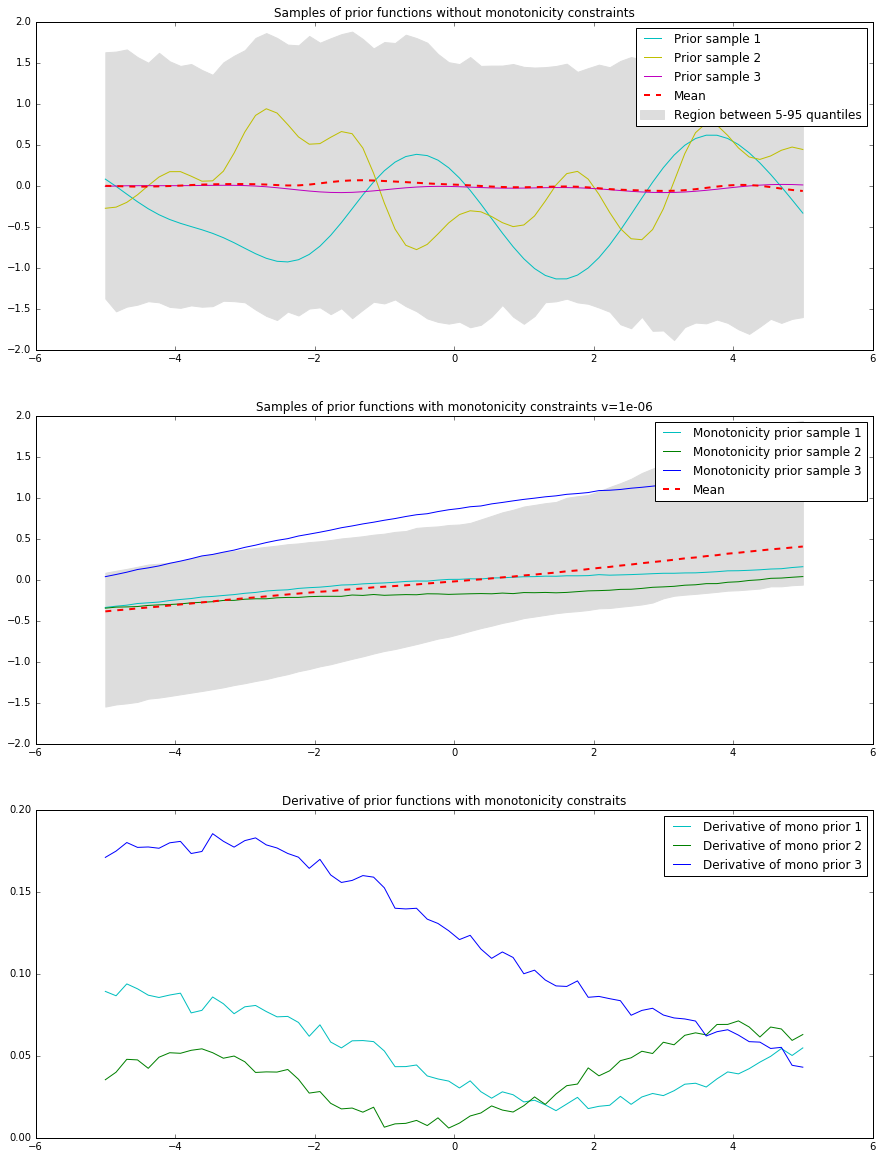

In [14]:
p = np.random.randint(sim_mono_prior.shape[0],size=3)
pp = np.random.randint(prior.shape[0],size=3)
pr_q5 = np.percentile(prior,5,axis=0)
pr_q95 = np.percentile(prior,95,axis=0)
pr_mean = np.mean(prior,axis=0)
m_pr_q5 = np.percentile(sim_mono_prior[0:,:cnt_xp],5,axis=0)
m_pr_q95 = np.percentile(sim_mono_prior[0:,:cnt_xp],95,axis=0)
m_pr_mean = np.mean(sim_mono_prior[0:,:cnt_xp],axis=0)


plt.figure(figsize=(15,20))

plt.subplot(311)
plt.title('Samples of prior functions without monotonicity constraints')
plt.plot(xp, prior[pp[0]], 'c')
plt.plot(xp, prior[pp[1]], 'y')
plt.plot(xp, prior[pp[2]], 'm')
plt.fill_between(xp, pr_q5, pr_q95, color="#dddddd",label="Region between 5-95 quantiles")
plt.plot(xp,pr_mean,'r--',lw=2,label="Mean" )
plt.legend()


plt.subplot(312)
plt.title('Samples of prior functions with monotonicity constraints v={}'.format(v_value))
plt.plot(xp, sim_mono_prior[p[0]][:cnt_xp], 'c')
plt.plot(xp, sim_mono_prior[p[1]][:cnt_xp], 'g')
plt.plot(xp, sim_mono_prior[p[2]][:cnt_xp], 'b')
plt.fill_between(xp, m_pr_q5, m_pr_q95, color="#dddddd")
plt.plot(xp,m_pr_mean,'r--',lw=2,label="Mean" )
plt.legend()

plt.subplot(313)
plt.title('Derivative of prior functions with monotonicity constraits')
plt.plot(xm, sim_mono_prior[p[0]][cnt_xp:], 'c')
plt.plot(xm, sim_mono_prior[p[1]][cnt_xp:], 'g')
plt.plot(xm, sim_mono_prior[p[2]][cnt_xp:], 'b')
#plt.legend()


plt.legend()
plt.savefig("./Fig/%s Prior.png"%(time.ctime()))
plt.show()

# Posterior 

In [15]:
posterior_model = StanModel_cache(model_code=open("../Stan files/posterior.stan").read())

Using cached StanModel


In [17]:
mono_posterior_model = StanModel_cache(model_code=open("../Stan files/posterior mono.stan").read())

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8aeaed3bf5ccce86b1b819214d5af0a4 NOW.


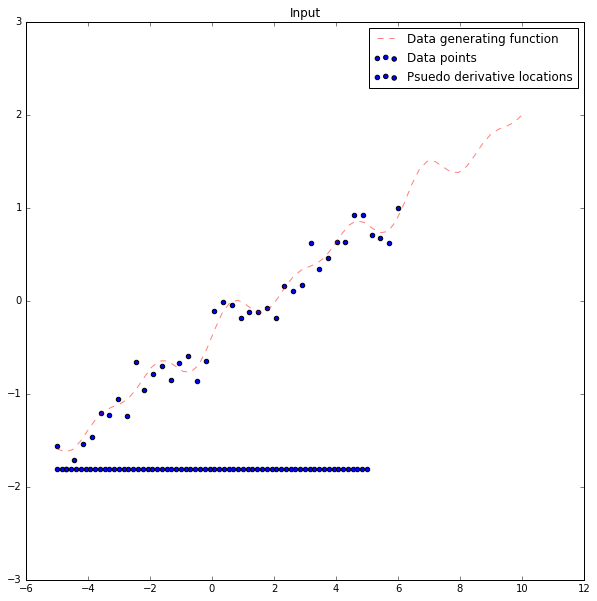

In [19]:
def func(x):
    return (np.sin(x*3)*0.5+np.sin(x*2)*0.5+x)



xdata = np.linspace(-5,6,40)
ydata = func(xdata) + np.random.normal(0,0.5,size=len(xdata))
x = np.linspace(-5,10,60)
y = func(x) 
ycombined = preprocessing.scale(np.append(ydata,y))
ydata = ycombined[:len(xdata)]
y = ycombined[len(xdata):]

plt.figure(figsize=(10,10))
plt.scatter(xdata,ydata,label="Data points")
plt.plot(x,y,'r--',alpha=0.5,label="Data generating function")
plt.scatter(xm,np.zeros_like(xm)+np.min(ycombined),label="Psuedo derivative locations")
plt.title('Input')

plt.legend()
plt.savefig("./Fig/%s Input.png"%(time.ctime()))

plt.show()

In [20]:
sig =0.3
v= 0.000001

posterior_data = dict(
    N = len(xdata),
    x = xdata,
    y = ydata,
    N_prm = len(x),
    x_prm = x,
    sig_var = sig
)

mono_posterior_data = dict(
    N = len(xdata),
    x = xdata,
    y = ydata,
    N_g = len(xm),
    x_g = xm,
    m = m,
    N_prm = len(x),
    x_prm = x,
    v = v,
    sig_var = sig
)

In [21]:
posterior_fit = posterior_model.sampling(data=posterior_data,iter=1000,chains=1)
print(posterior_fit)

Inference for Stan model: anon_model_4c8635eb3d0081962d7e50e2f766a468.
1 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=500.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
rho         3.08    0.21   1.56   1.15   1.82   2.73   3.99   7.36   54.0   1.01
alpha       0.96    0.03   0.33   0.53   0.72   0.89   1.13   1.72  155.0    1.0
eta[0]     -1.91    0.04   0.58  -3.11  -2.29  -1.85  -1.48  -1.01  197.0    1.0
eta[1]       0.3    0.09   0.68  -1.06   -0.2   0.32   0.79   1.64   60.0    1.0
eta[2]     -0.11    0.03   0.65  -1.38  -0.54  -0.11   0.31   1.15  500.0    1.0
eta[3]      -0.3    0.03   0.71  -1.63  -0.78  -0.36   0.14   1.21  500.0    1.0
eta[4]     -0.25    0.04    0.9  -1.93  -0.83  -0.29   0.35    1.6  500.0    1.0
eta[5]     -0.14    0.04   0.92  -1.82  -0.81  -0.11    0.5   1.55  500.0    1.0
eta[6]     -0.06    0.04    1.0  -2.05  -0.64 1.2e-3   0.63   1.87  500.0    1.0
eta[

In [22]:
mono_posterior_fit = mono_posterior_model.sampling(data=mono_posterior_data,iter=1000,chains=1)
print(mono_posterior_fit)

Inference for Stan model: anon_model_8aeaed3bf5ccce86b1b819214d5af0a4.
1 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=500.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
rho          8.6    0.42   3.85   2.63   5.63   8.16  10.92  17.55   84.0    1.0
alpha       1.42    0.05   0.47   0.68   1.04   1.35   1.75   2.47   77.0   1.02
eta[0]     -1.32    0.05   0.46  -2.37  -1.59  -1.22  -0.96  -0.66   71.0   1.01
eta[1]      1.35    0.05   0.59   0.33   0.93   1.31   1.72   2.64  128.0    1.0
eta[2]      0.14    0.04   0.97   -1.8  -0.52   0.13   0.85   1.92  500.0    1.0
eta[3]      0.02    0.05   0.94  -1.75  -0.59   0.02   0.67   1.76  387.0    1.0
eta[4]       0.1    0.05   0.91  -1.62  -0.54    0.1   0.71   1.78  354.0    1.0
eta[5]      0.03    0.06   0.99  -1.87  -0.67   0.07   0.72   1.84  234.0    1.0
eta[6]      0.03    0.04    1.0  -1.92  -0.64   0.06   0.66   1.98  500.0    1.0
eta[

In [24]:
sim_posterior = posterior_fit.extract(permuted=True)['y_prm']
mono_sim_posterior = mono_posterior_fit.extract(permuted=True)['y_prm']

p_mean = np.mean(sim_posterior,axis=0)
p_std = np.std(sim_posterior,axis=0)

m_p_mean = np.mean(mono_sim_posterior,axis=0)
m_p_std = np.std(mono_sim_posterior,axis=0)

p_q5 = np.percentile(sim_posterior, 5, axis=0)
p_q95 = np.percentile(sim_posterior, 95, axis=0)

m_p_q5 = np.percentile(mono_sim_posterior, 5, axis=0)
m_p_q95 = np.percentile(mono_sim_posterior, 95, axis=0)

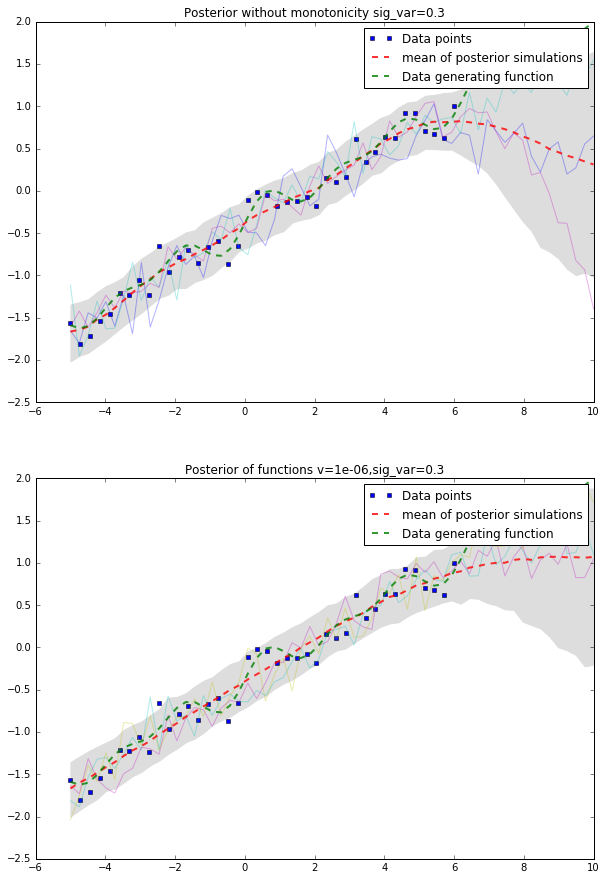

In [26]:
c = ['b', 'c', 'm', 'y']
p = np.random.randint(sim_posterior.shape[0],size=3)
pp = np.random.randint(mono_sim_posterior.shape[0],size=3)


fig,ax = plt.subplots(2,1)
fig.set_size_inches(10,15)
ax[0].set_title('Posterior without monotonicity sig_var={}'.format(sig))
ax[0].plot(xdata, ydata, 'bs', ms=4,label="Data points")#  
ax[0].plot(x, sim_posterior[p[0]], c[0],alpha=0.3)
ax[0].plot(x, sim_posterior[p[1]], c[1],alpha=0.3)
ax[0].plot(x, sim_posterior[p[2]], c[2],alpha=0.3)
ax[0].plot(x, p_mean,'r--',alpha=0.8,lw=2,label="mean of posterior simulations")
ax[0].plot(x,y,'g--',alpha=0.8,lw=2,label="Data generating function")
ax[0].fill_between(x, p_q5, p_q95, color="#dddddd")
ax[0].legend()


#plt.subplot(2,2,2)
ax[1].set_title('Posterior of functions v={},sig_var={}'.format(v,sig))
ax[1].plot(xdata, ydata, 'bs', ms=4,label="Data points")#
ax[1].fill_between(x, m_p_q5, m_p_q95, color="#dddddd")
ax[1].plot(x, mono_sim_posterior[pp[0]], c[1],alpha=0.3)
ax[1].plot(x, mono_sim_posterior[pp[1]], c[2],alpha=0.3)
ax[1].plot(x, mono_sim_posterior[pp[2]], c[3],alpha=0.3)
ax[1].plot(x, m_p_mean, 'r--',alpha=0.8, lw=2,label="mean of posterior simulations")
ax[1].plot(x,y,'g--',alpha=0.8,lw=2,label="Data generating function")
ax[1].legend()

plt.savefig("./Fig/%s Posterior.png"%(time.ctime()))
plt.show()